# Reinforcement Learning

This script implements a reinforcement learning setup with a DQN (Deep Q-Network) for a simple grid-based game, where the goal is for the agent to navigate a grid to reach a goal position.  

The grid size is defined by `d_state`, which determines the dimensions of the grid (e.g., a 5x5 grid if `d_state = 5`).

Each state in this environment is a vector that flattens the 2D grid into a 1D array.

The agent has a fixed number of possible actions, specified by `action_size`. For instance, if `action_size = 4`, the actions could correspond to moving up, down, left, or right within the grid.



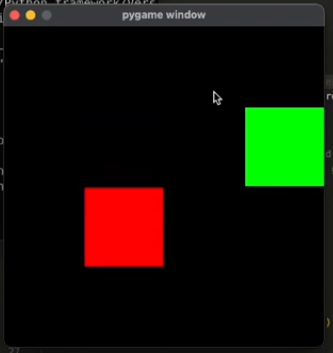

# key parameters for  reinforcement learning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import time
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import time
import math


# Initialize device properly
# device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device = 'cpu'
print(f"Using device: {device}")

num_episodes = 10000
d_state = 5
action_size = 4
discount_rate = 0.9
learning_rate = 1e-3 # 5e-4 -> 1e-3
eps_start = 1
eps_end = 0.01
eps_decay = 1500
time_step_reward = -1
dropout = 0.2
r_scaling = 2

Using device: cpu


# Neural Network for Q-Learning

* A simple feedforward network with one hidden layer, ReLU activation, and dropout.
* Kaiming He initialization is used for better performance with ReLU activation.

In [ ]:

class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

        self.dropout = nn.Dropout(p=dropout)
        # Initialize weights using Kaiming He initialization for ReLU
        nn.init.kaiming_uniform_(self.net[0].weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.net[2].weight, nonlinearity='relu')

    def forward(self, x):
        out = self.dropout(self.net(x))
        return out

# GridGame Class:

* Represents the game environment, including state representation, action execution, and reward calculation.
* The step method calculates rewards based on the distance to the goal and updates the state.

In [ ]:
class GridGame:
    def __init__(self, model):
        self.state_size = d_state ** 2
        self.action_size = action_size
        self.model = model
        self.reset()
        self.optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

    def reset(self):
        self.player_pos = (random.randint(0, d_state - 1), random.randint(0, d_state - 1))
        self.goal_pos = (random.randint(0, d_state - 1), random.randint(0, d_state - 1))
        while self.goal_pos == self.player_pos:
            self.goal_pos = (random.randint(0, d_state - 1), random.randint(0, d_state - 1))
        self.done = False
        self.state = self.get_state()

    def get_state(self):
        state = torch.zeros((d_state, d_state), device=device)
        state[self.player_pos[0], self.player_pos[1]] = 1
        state[self.goal_pos[0], self.goal_pos[1]] = 2
        return state.flatten().unsqueeze(0)

    def calculate_distance(self):
        # Convert the differences to tensors before calculating the distance
        a = torch.tensor((self.player_pos[0] - self.goal_pos[0])**2, device=device, dtype=torch.float)
        b = torch.tensor((self.player_pos[1] - self.goal_pos[1])**2, device=device, dtype=torch.float)
        return torch.sqrt(a + b)

    def step(self, action):
        moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right
        move = moves[action]
        prev_distance = self.calculate_distance()
        self.player_pos = ((self.player_pos[0] + move[0]) % d_state, (self.player_pos[1] + move[1]) % d_state)
        new_distance = self.calculate_distance()

        reward = time_step_reward  # Penalize each step to encourage efficiency
        delta_distance = prev_distance - new_distance

        if delta_distance > 0:
            reward += 3*delta_distance/d_state
        else:
            reward -= delta_distance/d_state

        if self.player_pos == self.goal_pos:
            reward += 100  # Large reward for reaching the goal
            self.done = True

        new_state = self.get_state()
        return new_state, reward, self.done

    def train_step(self, state, action, reward, next_state, done):
        action = action.view(1, -1)
        reward = torch.tensor([reward], device=device, dtype=torch.float)
        done = torch.tensor([done], device=device, dtype=torch.float)

        state_action_values = self.model(state).gather(1, action)
        next_state_values = self.model(next_state).max(1)[0].detach()

        expected_state_action_values = (next_state_values * discount_rate) * (1 - done) + torch.tanh(reward)*r_scaling

        loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Select Action Function

*  The select_action function determines which action the agent should take given the current state and episode number. It balances exploration and exploitation based on the current value of epsilon.


* Epsilon Decay: The epsilon_by_episode function ensures a gradual shift from exploration to exploitation during training by adjusting epsilon over episodes.

In [ ]:
def select_action(state, policy_net, episode):
    eps_threshold = epsilon_by_episode(episode)
    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(action_size)]], device=device, dtype=torch.long)

# Epsilon decay function
def epsilon_by_episode(episode):
    return eps_end + (eps_start - eps_end) * math.exp(-1. * episode / eps_decay)


# Training Loop

this loop iterates through multiple episodes, with each episode involving resetting the environment, selecting and executing actions, and updating the policy network based on the observed rewards and state transitions. The goal is for the agent to learn an effective policy by maximizing its total reward over many episodes.

In [ ]:
policy_net = DQN(d_state ** 2, action_size)
game = GridGame(policy_net)


start_time = time.time()
policy_net.train()

try:
    for episode in range(num_episodes):
        game.reset()
        total_reward = 0
        while not game.done:
            state = game.state
            action = select_action(state, policy_net, episode)
            next_state, reward, done = game.step(action.item())
            game.train_step(state, action, reward, next_state, done)
            game.state = next_state
            total_reward += reward

        if episode % 100 == 0:
            print(f"Episode {episode}: Total Reward: {total_reward:.2f}, Epsilon: {epsilon_by_episode(episode):.2f}")

except KeyboardInterrupt:
    print("Training stopped")

finally:
    print(f'Training took {time.time() - start_time} seconds')

torch.save(policy_net.state_dict(), 'model-v0.pth')
print('Model saved')

Episode 0: Total Reward: 56.75, Epsilon: 1.00
Episode 100: Total Reward: 87.91, Epsilon: 0.94
Episode 200: Total Reward: 97.80, Epsilon: 0.88
Episode 300: Total Reward: 80.74, Epsilon: 0.82
Episode 400: Total Reward: 75.94, Epsilon: 0.77
Episode 500: Total Reward: 96.49, Epsilon: 0.72
Episode 600: Total Reward: 72.66, Epsilon: 0.67
Episode 700: Total Reward: 98.34, Epsilon: 0.63
Episode 800: Total Reward: -11.40, Epsilon: 0.59
Episode 900: Total Reward: 94.27, Epsilon: 0.55
Episode 1000: Total Reward: 83.64, Epsilon: 0.52
Episode 1100: Total Reward: 90.32, Epsilon: 0.49
Episode 1200: Total Reward: 91.17, Epsilon: 0.45
Episode 1300: Total Reward: 95.79, Epsilon: 0.43
Episode 1400: Total Reward: 96.00, Epsilon: 0.40
Episode 1500: Total Reward: 94.89, Epsilon: 0.37
Episode 1600: Total Reward: 100.47, Epsilon: 0.35
Episode 1700: Total Reward: 97.60, Epsilon: 0.33
Episode 1800: Total Reward: 92.78, Epsilon: 0.31
Episode 1900: Total Reward: 97.51, Epsilon: 0.29
Episode 2000: Total Reward: 98

# Testing the performance of the trained reinforcement learning model

In [ ]:
policy_net.eval()
episode_moves = []
try:
    for x in range(100):
        game.reset()
        total_reward = 0
        episode_moves.append(0)
        while not game.done:
            state = game.state
            action = select_action(state, policy_net, 100000)
            next_state, reward, done = game.step(action.item())
            game.state = next_state
            total_reward += reward
            episode_moves[x] += 1

        print(f"Total Reward: {total_reward}")

except KeyboardInterrupt:
    print("Testing stopped")


Total Reward: 98.34163665771484
Total Reward: 99.66603088378906
Total Reward: 98.34163665771484
Total Reward: 97.69705200195312
Total Reward: 101.39411163330078
Total Reward: 96.43722534179688
Total Reward: 97.1187515258789
Total Reward: 96.54009246826172
Total Reward: 99.66603088378906
Total Reward: 97.34163665771484
Total Reward: 99.5999984741211
Total Reward: 98.34163665771484
Total Reward: 99.66603088378906
Total Reward: 98.8973617553711
Total Reward: 101.4000015258789
Total Reward: 99.5999984741211
Total Reward: 25.90019989013672
Total Reward: 97.43801879882812
Total Reward: 99.5999984741211
Total Reward: 96.36177825927734
Total Reward: 99.95147705078125
Total Reward: 97.69705200195312
Total Reward: 98.85659790039062
Total Reward: 97.96333312988281
Total Reward: 99.19999694824219
Total Reward: 99.19999694824219
Total Reward: 99.5999984741211
Total Reward: 98.34163665771484
Total Reward: 100.5999984741211
Total Reward: 98.163330078125
Total Reward: 100.5999984741211
Total Reward: 1

In [ ]:
print(f"Average moves: {sum(episode_moves)/len(episode_moves)}")

Average moves: 6.54
